In [1]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib import colors 
import evaluation.evaluate as evaluate

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
X_train, Y_train, trainFileList = bbdc.load_audioset("long_unbalanced_train_segments.csv", "unbalanced_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")
X_validation, Y_validation, validationFileList = bbdc.load_audioset("long_balanced_train_segments.csv", "balanced_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")
X_test, Y_test, testFileList = bbdc.load_audioset("long_eval_segments.csv", "eval_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")

16186it [08:08, 33.16it/s]
573it [00:18, 31.80it/s]
585it [00:18, 32.33it/s]


In [4]:
Y_train[:,0]=0
Y_validation[:,0]=0
Y_test[:,0]=0

In [5]:
X_train_new = np.append(X_train, X_validation, axis=0)
X_train_new = np.append(X_train_new, X_test, axis=0)
Y_train_new = np.append(Y_train, Y_validation, axis=0)
Y_train_new = np.append(Y_train_new, Y_test, axis=0)

In [6]:
shuffledIndices = np.random.permutation(X_train_new.shape[0])
X_train_new = X_train_new[shuffledIndices]
Y_train_new = Y_train_new[shuffledIndices]
length = len(shuffledIndices)
X_validation_new = X_train_new[int(0.8*length):int(0.9*length)]
Y_validation_new = Y_train_new[int(0.8*length):int(0.9*length)]
X_test_new = X_train_new[int(0.9*length):]
Y_test_new = Y_train_new[int(0.9*length):]
X_train_new = X_train_new[:int(0.8*length)]
Y_train_new = Y_train_new[:int(0.8*length)]

In [7]:
channels = [25, 20, 15]
numClasses=13
padding = "same"
input_layer = layers.Input(shape=(None, 32))
#input_layer = layers.Input(shape=X_train_new[0].shape)
x = input_layer
x = layers.Conv1D(channels[0], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[0], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(channels[1], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[1], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[1], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(channels[2], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[2], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(numClasses, kernel_size=1, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Activation(keras.activations.softmax)(x)

model = keras.models.Model(inputs=input_layer, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 32)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 25)          2425      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 25)          1900      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 25)          100       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 25)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          1520      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          1220  

In [8]:
opt = keras.optimizers.Adam(learning_rate=0.001)
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train_new, Y_train_new, batch_size=10, epochs=100, shuffle=True, validation_data=(X_validation_new, Y_validation_new), callbacks=[checkpoint])

Epoch 1/100
1388/1388 [==============================] - 55s 24ms/step - loss: 2.2496 - mae: 0.1239 - accuracy: 0.3301 - val_loss: 1.6632 - val_mae: 0.1049 - val_accuracy: 0.4908

Epoch 00001: val_loss improved from inf to 1.66316, saving model to model.h5
Epoch 2/100
1388/1388 [==============================] - 8s 6ms/step - loss: 1.6397 - mae: 0.1040 - accuracy: 0.4874 - val_loss: 1.5791 - val_mae: 0.1017 - val_accuracy: 0.5271

Epoch 00002: val_loss improved from 1.66316 to 1.57908, saving model to model.h5
Epoch 3/100
1388/1388 [==============================] - 8s 6ms/step - loss: 1.5040 - mae: 0.0968 - accuracy: 0.5327 - val_loss: 1.5277 - val_mae: 0.0932 - val_accuracy: 0.5323

Epoch 00003: val_loss improved from 1.57908 to 1.52771, saving model to model.h5
Epoch 4/100
1388/1388 [==============================] - 8s 6ms/step - loss: 1.3929 - mae: 0.0914 - accuracy: 0.5659 - val_loss: 1.3486 - val_mae: 0.0879 - val_accuracy: 0.5773

Epoch 00004: val_loss improved from 1.52771 to 

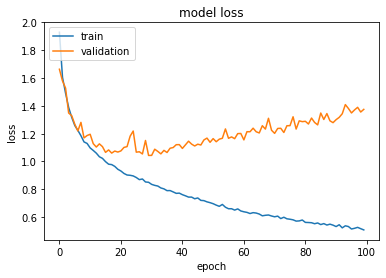

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

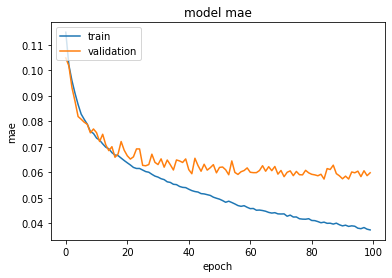

In [10]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

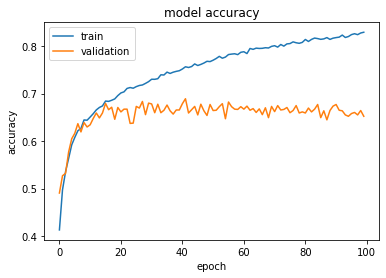

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
model.save("classification100.h5")

In [ ]:
model = keras.models.load_model("model.h5")

In [30]:
prediction = model.predict(X_test_new)
scores = model.evaluate(X_test_new, Y_test_new)

55/55 [==============================] - 0s 4ms/step - loss: 1.3457 - mae: 0.0586 - accuracy: 0.6611


In [38]:
index = 6
print(bbdc.invLabelMap[np.argmax(prediction[index])])
print(bbdc.invLabelMap[np.argmax(Y_test_new[index])])

Bark
Bark


# Prediction der Test-Daten

In [45]:
firstPredictionFile = "../predictions/jannes/LP1d_Prediction_mel_pp_test.csv"
firstPrediction = pd.read_csv(firstPredictionFile)
pathToDataDir = "../data/"
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"
firstPrediction.head()

,filename,onset,offset,event_label
0,09001_mix.wav,1.152882,2.280702,Cough
1,09001_mix.wav,2.305764,3.107769,Fireworks
2,09001_mix.wav,3.884712,5.889724,Cheering
3,09001_mix.wav,7.819549,9.724311,Meow
4,09002_mix.wav,0.225564,0.877193,Shout


In [47]:
currentFile = ""
X = []
Y = []
for index, row in firstPrediction.iterrows():
    if currentFile!=row["filename"]:
        currentFile = row["filename"]
        features = np.genfromtxt(pathToDataDir + pathToDataset +"/dev/" + row["filename"].replace(".wav", ".csv"), delimiter=',')
    indices = np.logical_and(features[:,0]>=row["onset"], features[:,0]<=row["offset"])
    X.append(features[indices, 1:])
    Y.append(bbdc.LABEL_DICT[row["event_label"]])

In [48]:
secondPrediction = []
for i in range(len(X)):
    if X[i].shape[0]>=44:
        pred = np.argmax(model.predict(np.array([X[i]])))
        if pred==0:
            secondPrediction.append(Y[i])
        else:
            secondPrediction.append(pred)
    else:
        secondPrediction.append(Y[i])

In [49]:
secondLabel = [bbdc.invLabelMap[pred] for pred in secondPrediction]

In [50]:
secondPredictionDf = firstPrediction.copy()
secondPredictionDf["event_label"]=secondLabel
secondPredictionDf.to_csv("../predictions/jannes/secondPrediction.csv", index=False)

In [51]:
print("Score was: ")
print(evaluate.evaluate(firstPredictionFile, "./../data/test.csv"))
print("Score now is: ")
print(evaluate.evaluate("../predictions/jannes/secondPrediction.csv", "./../data/test.csv"))

Score was: 
(0.831134109757114, 'Valid file')
Score now is: 
(0.39717695416363313, 'Valid file')


# Prediction der gesamten Trainingsdaten

In [53]:
pathToDataDir = "../data/"
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"
firstPredictionFile = pathToDataDir+pathToDataset+"dev-labels.csv"
firstPrediction = pd.read_csv(firstPredictionFile)
firstPrediction.head()

,filename,onset,offset,event_label
0,00001_mix.wav,2.852143,3.852143,Cheering
1,00001_mix.wav,5.468056,6.468056,Church_bell
2,00002_mix.wav,0.433088,1.433088,Doorbell
3,00002_mix.wav,2.510292,3.510292,Shatter
4,00002_mix.wav,5.106170,6.106170,Church_bell


In [54]:
currentFile = ""
X = []
Y = []
for index, row in firstPrediction.iterrows():
    if currentFile!=row["filename"]:
        currentFile = row["filename"]
        features = np.genfromtxt(pathToDataDir + pathToDataset +"/dev/" + row["filename"].replace(".wav", ".csv"), delimiter=',')
    indices = np.logical_and(features[:,0]>=row["onset"], features[:,0]<=row["offset"])
    X.append(features[indices, 1:])
    Y.append(bbdc.LABEL_DICT[row["event_label"]])

In [55]:
secondPrediction = []
for i in range(len(X)):
    if X[i].shape[0]>=44:
        pred = np.argmax(model.predict(np.array([X[i]])))
        if pred==0:
            secondPrediction.append(Y[i])
        else:
            secondPrediction.append(pred)
    else:
        secondPrediction.append(Y[i])

secondLabel = [bbdc.invLabelMap[pred] for pred in secondPrediction]
secondPredictionDf = firstPrediction.copy()
secondPredictionDf["event_label"]=secondLabel
secondPredictionDf.to_csv("../predictions/jannes/secondPrediction.csv", index=False)
print("Score now is: ")
print(evaluate.evaluate("../predictions/jannes/secondPrediction.csv", pathToDataDir+pathToDataset+"dev-labels.csv"))

Score now is: 
(0.4670578824713174, 'Valid file')


# Prediction der Challenge-Daten

In [12]:
pathToDataDir = "../data/"
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"
firstPredictionFile = "../submissions/submission03/2d_PredictionChallenge_mel.csv"
firstPrediction = pd.read_csv(firstPredictionFile)
firstPrediction.head()

,filename,onset,offset,event_label,MeanProb,MedianProb
0,10001_mix.wav,2.857143,3.809524,Cheering,0.822208,0.996878
1,10001_mix.wav,5.513784,6.441103,Doorbell,0.774813,0.947341
2,10002_mix.wav,0.426065,2.907268,Cheering,0.631532,0.923654
3,10002_mix.wav,2.932331,3.458647,Bark,0.887923,0.942197
4,10002_mix.wav,5.112782,6.090226,Meow,0.879442,0.996213


In [14]:
currentFile = ""
X = []
Y = []
for index, row in firstPrediction.iterrows():
    if currentFile!=row["filename"]:
        currentFile = row["filename"]
        features = np.genfromtxt(pathToDataDir + pathToDataset +"/eval/" + row["filename"].replace(".wav", ".csv"), delimiter=',')
    indices = np.logical_and(features[:,0]>=row["onset"], features[:,0]<=row["offset"])
    X.append(features[indices, 1:])
    Y.append(bbdc.LABEL_DICT[row["event_label"]])

In [15]:
secondPrediction = []
for i in range(len(X)):
    if X[i].shape[0]>=44:
        pred = np.argmax(model.predict(np.array([X[i]])))
        if pred==0:
            secondPrediction.append(Y[i])
        else:
            secondPrediction.append(pred)
    else:
        secondPrediction.append(Y[i])

secondLabel = [bbdc.invLabelMap[pred] for pred in secondPrediction]
secondPredictionDf = firstPrediction.copy()
secondPredictionDf["event_label"]=secondLabel
secondPredictionDf.to_csv("../predictions/jannes/secondPredictionChallenge.csv", index=False)

In [16]:
secondPredictionDf.head()

,filename,onset,offset,event_label,MeanProb,MedianProb
0,10001_mix.wav,2.857143,3.809524,Cheering,0.822208,0.996878
1,10001_mix.wav,5.513784,6.441103,Doorbell,0.774813,0.947341
2,10002_mix.wav,0.426065,2.907268,Bark,0.631532,0.923654
3,10002_mix.wav,2.932331,3.458647,Bark,0.887923,0.942197
4,10002_mix.wav,5.112782,6.090226,Meow,0.879442,0.996213
